Loading results from: /home/benny/Repos/SmoothieFDR/cache/results.pkl
Successfully loaded data for 15 datasets.
threshold:0.02869042619084873
threshold:0.0294005740152216
threshold:0.01570902024359564
threshold:0.03943543593424971
threshold:0.03853592587348071
threshold:0.02088995698765966
threshold:0.02981369241512623
threshold:0.03275333421618664
threshold:0.03185081217830956
threshold:0.03582251210430638
threshold:0.03407630069397968
threshold:0.03832860914114272
threshold:0.02513890548648876
threshold:0.03608628469941075
threshold:0.02985744032210342

Global Inference AUC: 0.4870
Total Unseen Nodes Evaluated: 15000


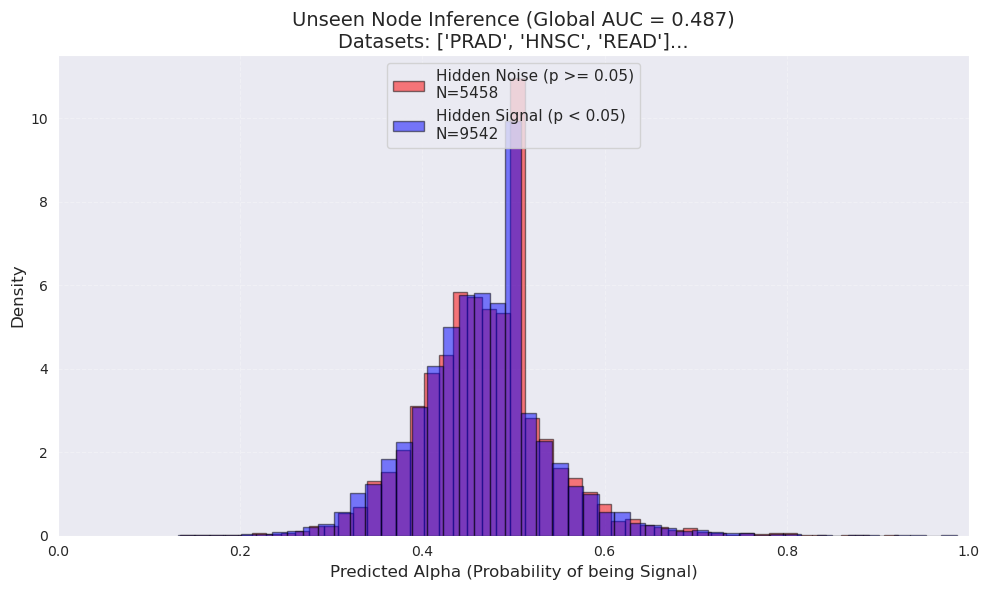

In [26]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy.stats import norm

from statsmodels.stats.multitest import multipletests
# --- 1. Load the Results ---
file_path = "/home/benny/Repos/SmoothieFDR/cache/results.pkl"

print(f"Loading results from: {file_path}")
with open(file_path, 'rb') as f:
    results_dict = pickle.load(f)

print(f"Successfully loaded data for {len(results_dict)} datasets.")

# --- 2. Aggregate Data ---
# We collect all "unseen" points from all datasets into two big buckets
all_signal_preds = []  # Predicted alpha for genes that were ACTUALLY significant
all_noise_preds = []   # Predicted alpha for genes that were ACTUALLY noise

for dname, data in results_dict.items():
    # hidden p-values (the truth we hid from the model)
    p_hidden = data['y_hidden_pvals']

    # predicted alpha (the model's guess based only on neighbors)
    alpha_pred = data['alpha_pred']

    rejected, _, _, _ = multipletests(data["y_hidden_pvals"], alpha=0.05, method='fdr_bh')
    threshold = data["y_hidden_pvals"][rejected].max() if rejected.any() else 0.0
    print(f"threshold:{threshold}")
    # Define "Signal" vs "Noise" based on the hidden p-value
    is_signal = p_hidden < threshold

    all_signal_preds.extend(alpha_pred[is_signal])
    all_noise_preds.extend(alpha_pred[~is_signal])

# --- 3. Calculate Global AUC ---
# How well did the graph structure predict the p-values?
y_true = np.concatenate([np.zeros(len(all_noise_preds)), np.ones(len(all_signal_preds))])
y_scores = np.concatenate([all_noise_preds, all_signal_preds])
global_auc = roc_auc_score(y_true, y_scores)

print(f"\nGlobal Inference AUC: {global_auc:.4f}")
print(f"Total Unseen Nodes Evaluated: {len(y_true)}")

# --- 4. Plot Histogram ---
plt.figure(figsize=(10, 6))

# Plot Noise (Red)
if len(all_noise_preds) > 0:
    plt.hist(all_noise_preds, bins=50, alpha=0.5, color='red', density=True,
             label=f'Hidden Noise (p >= 0.05)\nN={len(all_noise_preds)}', edgecolor='black')

# Plot Signal (Blue)
if len(all_signal_preds) > 0:
    plt.hist(all_signal_preds, bins=50, alpha=0.5, color='blue', density=True,
             label=f'Hidden Signal (p < 0.05)\nN={len(all_signal_preds)}', edgecolor='black')

plt.title(f"Unseen Node Inference (Global AUC = {global_auc:.3f})\nDatasets: {list(results_dict.keys())[:3]}...", fontsize=14)
plt.xlabel("Predicted Alpha (Probability of being Signal)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(loc='upper center', fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlim(0, 1)

plt.tight_layout()
plt.show()

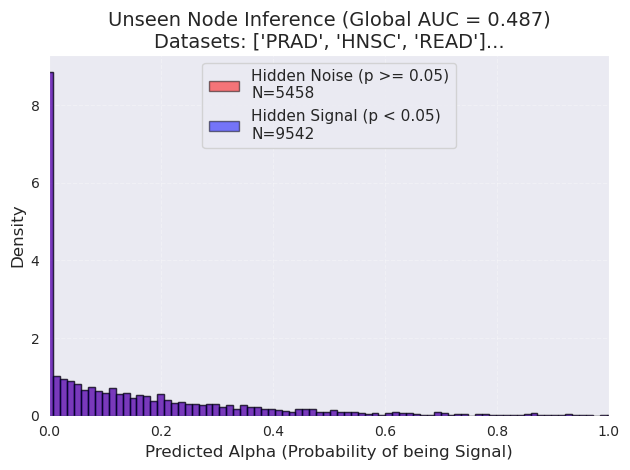

In [30]:

if len(all_noise_preds) > 0:
    plt.hist(np.log(np.array(all_signal_preds)/(1-np.array(all_signal_preds))), bins=500, alpha=0.5, color='red', density=True,
             label=f'Hidden Noise (p >= 0.05)\nN={len(all_noise_preds)}', edgecolor='black')

# Plot Signal (Blue)
if len(all_signal_preds) > 0:
    plt.hist(np.log(np.array(all_signal_preds)/(1-np.array(all_signal_preds))), bins=500, alpha=0.5, color='blue', density=True,
             label=f'Hidden Signal (p < 0.05)\nN={len(all_signal_preds)}', edgecolor='black')

plt.title(f"Unseen Node Inference (Global AUC = {global_auc:.3f})\nDatasets: {list(results_dict.keys())[:3]}...", fontsize=14)
plt.xlabel("Predicted Alpha (Probability of being Signal)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(loc='upper center', fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlim(0, 1)

plt.tight_layout()
plt.show()

In [16]:
def estimate_densities(p_values):
    f0_vals = np.ones_like(p_values)
    p_clipped = np.clip(p_values, 1e-10, 1 - 1e-10)
    z = norm.ppf(1 - p_clipped)
    mask = p_values < 0.2
    mu, sig = (np.mean(z[mask]), np.std(z[mask])) if mask.sum() > 10 else (2.5, 1.0)
    f1_vals = np.clip(norm.pdf(z, loc=mu, scale=sig) / norm.pdf(z), 0, 5000.0)
    return f0_vals, f1_vals


Global lfdr-based AUC: 0.9955
Mean lfdr - True Signal: 0.0316
Mean lfdr - True Noise: 0.7696


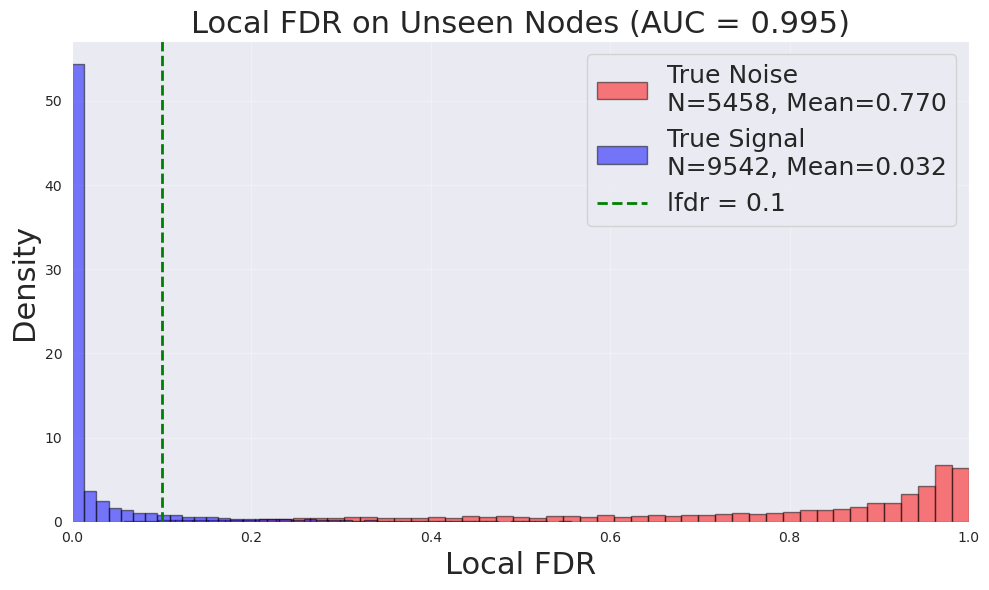

In [20]:
# --- Calculate local FDR for each unseen point ---
all_signal_lfdr = []
all_noise_lfdr = []

for dname, data in results_dict.items():
    p_hidden = data['y_hidden_pvals']
    alpha_pred = data['alpha_pred']

    # Get f0 and f1 for these specific p-values
    f0, f1 = estimate_densities(p_hidden)

    # Calculate lfdr = (alpha * f0) / (alpha * f0 + (1-alpha) * f1)
    numerator = alpha_pred * f0
    denominator = alpha_pred * f0 + (1 - alpha_pred) * f1
    lfdr = numerator / (denominator + 1e-12)
    lfdr = np.clip(lfdr, 0, 1)

    # Define ground truth using BH
    rejected, _, _, _ = multipletests(p_hidden, alpha=0.05, method='fdr_bh')
    threshold = p_hidden[rejected].max() if rejected.any() else 0.0

    is_signal = p_hidden < threshold
    all_signal_lfdr.extend(lfdr[is_signal])
    all_noise_lfdr.extend(lfdr[~is_signal])

all_signal_lfdr = np.array(all_signal_lfdr)
all_noise_lfdr = np.array(all_noise_lfdr)

# --- Calculate AUC ---
y_true = np.concatenate([np.ones(len(all_signal_lfdr)), np.zeros(len(all_noise_lfdr))])
y_scores = np.concatenate([1 - all_signal_lfdr, 1 - all_noise_lfdr])  # Invert: lower lfdr = higher score
global_auc = roc_auc_score(y_true, y_scores)

print(f"\nGlobal lfdr-based AUC: {global_auc:.4f}")
print(f"Mean lfdr - True Signal: {all_signal_lfdr.mean():.4f}")
print(f"Mean lfdr - True Noise: {all_noise_lfdr.mean():.4f}")

# --- Plot ---
plt.figure(figsize=(10, 6))

plt.hist(all_noise_lfdr, bins=50, alpha=0.5, color='red', density=True,
         label=f'True Noise\nN={len(all_noise_lfdr)}, Mean={all_noise_lfdr.mean():.3f}',
         edgecolor='black')

plt.hist(all_signal_lfdr, bins=50, alpha=0.5, color='blue', density=True,
         label=f'True Signal\nN={len(all_signal_lfdr)}, Mean={all_signal_lfdr.mean():.3f}',
         edgecolor='black')

plt.axvline(0.1, color='green', linestyle='--', linewidth=2, label='lfdr = 0.1')

plt.title(f"Local FDR on Unseen Nodes (AUC = {global_auc:.3f})", fontsize=22)
plt.xlabel("Local FDR", fontsize=22)
plt.ylabel("Density", fontsize=22)
plt.legend(loc='upper right',fontsize=18)
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

In [9]:
threshold

0.06576221973805167